<a href="https://colab.research.google.com/github/faheemkhaskheli9/Deep-Learning-Basic-Keras/blob/main/3D_CNN_small.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
cd '/content/drive/My Drive'

/content/drive/My Drive


In [ ]:
import cv2
import numpy as np
import os
#from keras.utils import plot_model
import time
import matplotlib.pyplot as plt
import imutils

from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix
from scipy.ndimage.interpolation import zoom

from keras.utils import np_utils
import tensorflow as tf
from keras import backend as K
from tensorflow.python.client import device_lib
from keras.callbacks import ModelCheckpoint
from keras.regularizers import l2,l1
import gc
import math

from keras.optimizers import Adam, SGD
print(tf.__version__)

Using TensorFlow backend.


1.15.0


In [ ]:
from keras.models import Sequential,Model

from keras.callbacks import ModelCheckpoint

from keras.layers import Dense, Dropout, Activation, Flatten, Reshape, LeakyReLU, Input
from keras.layers import multiply, concatenate, LSTM, ConvLSTM2D, GlobalAveragePooling3D, Conv2D, BatchNormalization, GlobalMaxPooling2D, GlobalMaxPooling3D
from keras.layers import Convolution3D, MaxPooling3D, SpatialDropout3D, UpSampling3D, TimeDistributed, Convolution2D, MaxPooling2D, SpatialDropout2D,Concatenate

In [ ]:
div = 4
desired_fps = 5
img_rows = 320//div
img_cols = 320//div
clip_time = 3
vid_depth = desired_fps * clip_time
img_channel = 1

print(img_rows,img_cols,vid_depth)

80 80 15


In [ ]:
paths = [['hmdb51','hmdb'],['ucf101','ucf101']]
model_paths = ['CNNLSTM2D.h5','Time_2DCNN_LSTM.h5','Conv3D.h5','two_stream.h5']
base_path = '/content/drive/My Drive/'

current_model = model_paths[3]
current_data = 0

load_weights = 0
checkpoint_active = 0

#dataset_path = "Video data"
dataset_path = base_path+paths[ current_data ][0]
model_path = base_path+"video dataset/Model/"+paths[ current_data ][1] + "/" + str(img_rows) +"x" + str(img_cols)+"_" +current_model

In [ ]:
print(model_path)

/content/drive/My Drive/video dataset/Model/hmdb/80x80_two_stream.h5


In [ ]:
def image_augmentation(frame):
  zooming = True

  # Brightness Level
  brightness = True
  increase = np.random.randint(-100,100,dtype='int8')

  # Rotate Angle
  ratation = True
  angle = np.random.randint(-45,45)
  flipping = np.random.choice([True,False])

  if brightness:
    hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV) #convert it to hsv
    v = hsv[:, :, 2]
    if increase > 0:
      v = np.where(v <= 255 - increase, v + increase, 255)
    if increase < 0:
      v = np.where(v >=  -1 * increase, v + increase,0)
    hsv[:, :, 2] = v
    img = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)
    frame = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  else:
    frame = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  ## Rotation
  if ratation:
    frame = imutils.rotate(frame, angle)
  ## Zooming
  if zooming:
    zoom_factor = 1.3
    #frame3 = zoom(frame, zoom_factor)
  ## Flip
  if flipping:
    frame = cv2.flip(frame, 1)

  err = 10
  r = np.random.randint(-err,err,(frame.shape[0],frame.shape[1]))
  frame = frame + r
  frame[frame > 255] = 255
  frame[frame < 0] = 0

  return frame

In [ ]:
def load_labels():
  unique_labels = []
  names_label = []

  if current_data == 1:
    video_path = dataset_path+'/Videos/'
  elif current_data == 0:
    video_path = dataset_path+'/videos/'
  for l in os.listdir(video_path):
    unique_labels.append(l)
    print(l)
    for v in os.listdir(video_path+l):
      vid = video_path+l+"/"+v
      names_label.append([vid,l])
  return np.array(names_label)

def load_videos(videos,augmentation=False):
  dataset = []
  for v in videos:
    frames = []
    if current_data == 1:
      cap = cv2.VideoCapture(dataset_path+'/Videos/'+v)
    elif current_data == 0:
      cap = cv2.VideoCapture(dataset_path+'/videos/'+v)

   # print('>',dataset_path+'/Videos/'+v)
    fps = cap.get( desired_fps )
    fn = 1
    fps = cap.get(cv2.CAP_PROP_FPS)
    fc = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    tf = math.floor(fps/ desired_fps )
    if (tf * vid_depth) > fc:
      tf = math.floor(fc/ vid_depth)
    if tf == 0:
      tf = 1

    while(cap.isOpened()):
      ret, frame = cap.read()
      fn+=1

      #plt.imshow( frame ,cmap='gray')
      #plt.show()

      if len(frames) == vid_depth:
        break

      if fn % tf == 0:
        try:
          frame=cv2.resize(frame,(img_rows,img_cols),interpolation=cv2.INTER_AREA)
        except:
          frames.append(frames[-1])
          continue
          print(tf,fc,fn,v)
        if augmentation:
          frame = image_augmentation(frame)
        elif img_channel == 1:
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

        frame = np.array(frame, dtype='float16')
        frame /= 255
        if img_channel == 1:
          frame = np.reshape(frame,(frame.shape[0],frame.shape[1],1))
        frames.append(frame)
    cap.release()
    #cv2.destroyAllWindows()
    inputs = np.array(frames)
    #ipt=np.rollaxis(np.rollaxis(inputs,2,0),2,0)
    dataset.append(inputs)
  return dataset

In [ ]:
if current_data == 1:
  X_test = []
  with open(dataset_path+"/testlist03.txt") as f:
    X_test = (f.read().split('\n'))
  X_test = np.array(X_test)

  X_train = []
  with open(dataset_path+"/trainlist03.txt") as f:
    X_train = (f.read().split('\n'))

  y_train = []
  X_train_2 = []
  for i in X_train:
    if i.split('/')[0] == '':
      print(i)
    else:
      y_train.append(i.split('/')[0])
    X_train_2.append(i.split(' ')[0])

  X_train = X_train_2
  del X_train_2
  y_test = []
  for i in X_test:
    if i.split('/')[0] != '':
      y_test.append(i.split('/')[0])
  print(len(y_train))
  print(len(y_test))

  X_test = X_test[:-1]

if current_data == 0:
  name_labels = load_labels()
  X_train, X_test, y_train, y_test = train_test_split(name_labels[:,0], name_labels[:,1], test_size=0.33, random_state=2019, stratify=name_labels[:,1])
le = preprocessing.LabelEncoder()
le.fit(y_train)
y_train_encoding = le.transform(y_train)
y_test_encoding = le.transform(y_test)

y_train_cat = np_utils.to_categorical(y_train_encoding)
y_test_cat = np_utils.to_categorical(y_test_encoding)

sword_exercise
throw
stand
wave
turn
somersault
walk
swing_baseball
talk
sword
run
shake_hands
smile
ride_horse
smoke
situp
shoot_ball
sit
shoot_bow
shoot_gun
ride_bike
punch
pushup
kiss
push
kick_ball
pour
laugh
pick
pullup
fencing
eat
hit
kick
hug
flic_flac
fall_floor
jump
golf
handstand
catch
clap
chew
climb_stairs
draw_sword
dive
dribble
cartwheel
climb
drink
brush_hair


In [ ]:
X_train = list()
y_train = list()
X_test = list()
y_test = list()
required_split = 'split1.txt'
for files in os.listdir(dataset_path+"/splits/"):
  l = files.split('_')
  labs = list()
  for i in l:
    if 'split1.txt' != i and 'split2.txt' != i and 'split3.txt' != i and 'test' != i :
      labs.append(i)
  labs = '_'.join(labs)

  if required_split in files:
    with open(dataset_path+"/splits/"+files) as f:
      data = (f.read().split('\n'))
      for i in data:
        if i != '':
          dd = i.split(' ')
          if dd[1] == '1':
            X_train.append(labs+'/'+dd[0])
            y_train.append(labs)
          elif dd[1] == '2':
            X_test.append(labs+'/'+dd[0])
            y_test.append(labs)

#    print(f)

In [ ]:
v = load_videos(X_train[2:3])
print(np.array(v).shape)

(1, 15, 80, 80, 1)


In [ ]:
le = preprocessing.LabelEncoder()
le.fit(y_train)
y_train_encoding = le.transform(y_train)
y_test_encoding = le.transform(y_test)

y_train_cat = np_utils.to_categorical(y_train_encoding)
y_test_cat = np_utils.to_categorical(y_test_encoding)

indexs = np.array(range(len(X_train)))

In [ ]:
for i in range(len(X_train)):
  if X_train[i] == '':
    del X_train[i]
    print('o')

In [ ]:
classes = y_train_cat.shape[1]
print(classes)

51


(2, 15, 80, 80, 1)


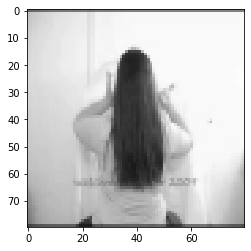

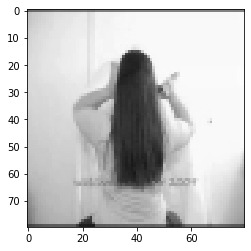

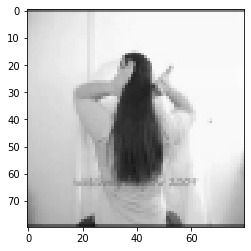

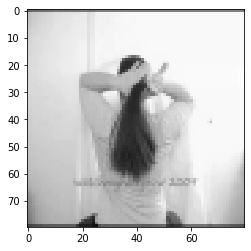

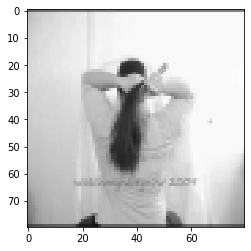

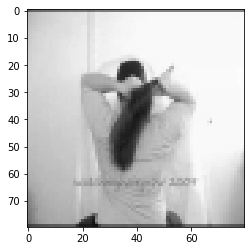

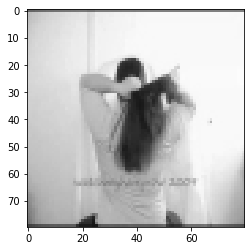

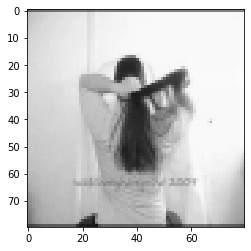

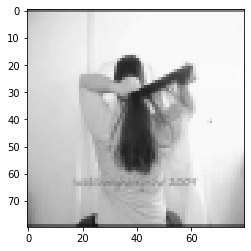

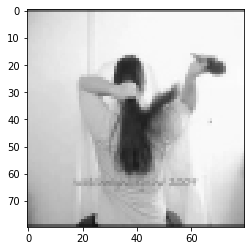

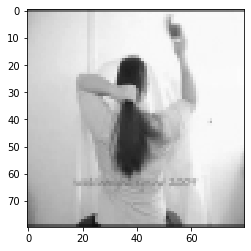

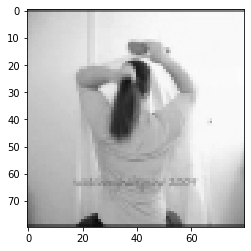

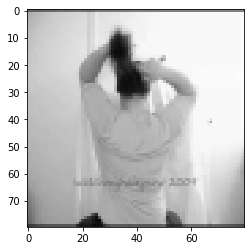

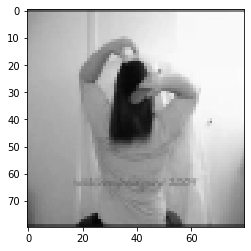

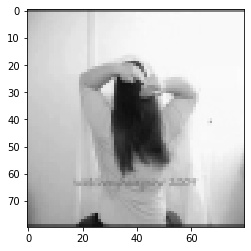

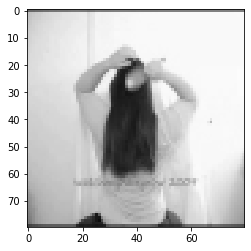

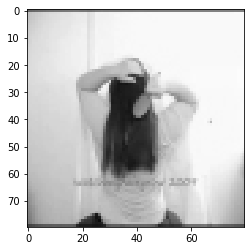

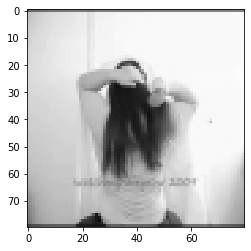

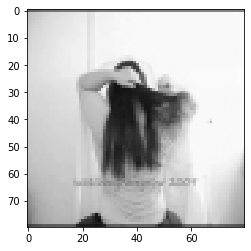

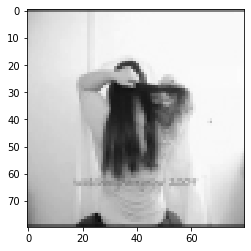

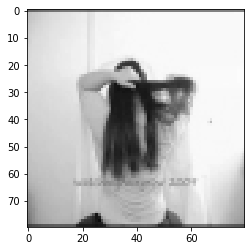

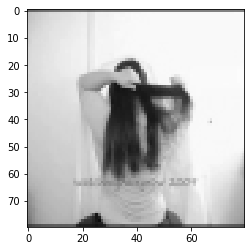

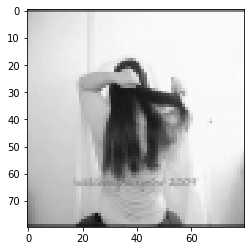

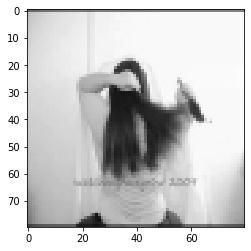

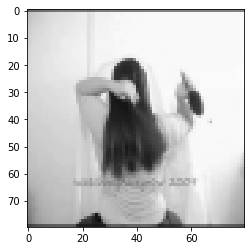

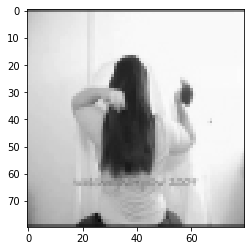

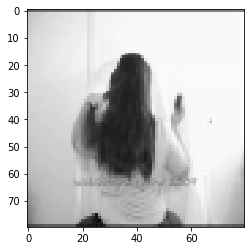

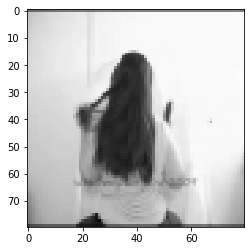

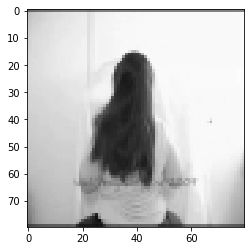

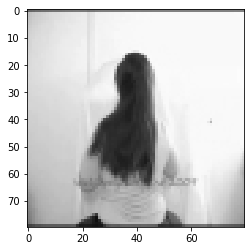

In [ ]:
v = load_videos(X_train[0:2],False)
print(np.array(v).shape)
for vi in v:
  for f in vi:
    f = np.array(f*255,dtype='uint8')
    f1 = cv2.cvtColor(f,cv2.COLOR_GRAY2RGB)
    plt.imshow(f1)
    plt.show()

In [ ]:
dimension = (vid_depth,img_cols,img_rows,img_channel)
droprate = 0.17

# kernel_regularizer=l2(weight_decay)
weight_decay = 0.0
def create_model():

  model = Sequential()

  conv_3_10 = [3,11,11]
  conv_333 = [3,3,3]

  if current_model == 'two_stream.h5':
    droprates = [0.1,0.4,0.6,0.6,0.6]

    inp1 = Input(shape=dimension)
    m1 = ConvLSTM2D(8, kernel_size=(3, 3),padding='same', dropout= droprates[1], recurrent_dropout=droprates[1],kernel_regularizer=l2(0.001), return_sequences=True)(inp1)
    m1 = MaxPooling3D((2,2,2))(m1)
    m1 = BatchNormalization()(m1)
    m1 = Dropout(droprates[1])(m1)
    m1 = ConvLSTM2D(16, kernel_size=(3, 3),padding='same', dropout= droprates[1], recurrent_dropout=droprates[1],kernel_regularizer=l2(0.001), return_sequences=True)(m1)
    m1 = MaxPooling3D((2,2,2))(m1)
    m1 = BatchNormalization()(m1)
    m1 = Dropout(droprates[1])(m1)
    m1 = ConvLSTM2D(32, kernel_size=(3, 3),padding='same', dropout= droprates[1], recurrent_dropout=droprates[1],kernel_regularizer=l2(0.001), return_sequences=True)(m1)
    m1 = MaxPooling3D((2,2,2))(m1)
    m1 = BatchNormalization()(m1)
    m1 = Dropout(droprates[2])(m1)
    m1 = ConvLSTM2D(64, kernel_size=(3, 3),padding='same', dropout= droprates[1], recurrent_dropout=droprates[1],kernel_regularizer=l2(0.001), return_sequences=False)(m1)

    inp2 = Input(shape=(img_cols,img_rows,img_channel))
    m2 = Conv2D(64, kernel_size=(3, 3),padding='same',kernel_regularizer=l2(0.001))(inp2)
    m2 = MaxPooling2D((2,2))(m2)
    m2 = BatchNormalization()(m2)
    m2 = Dropout(droprates[1])(m2)
    m2 = Conv2D(64, kernel_size=(3, 3),padding='same',kernel_regularizer=l2(0.001))(m2)
    m2 = MaxPooling2D((2,2))(m2)
    m2 = BatchNormalization()(m2)
    m2 = Dropout(droprates[1])(m2)
    m2 = Conv2D(64, kernel_size=(3, 3),padding='same',kernel_regularizer=l2(0.001))(m2)
    m2 = MaxPooling2D((2,2))(m2)
    m2 = BatchNormalization()(m2)
    m2 = Dropout(droprates[2])(m2)
    m2 = Conv2D(64, kernel_size=(3, 3),padding='same',kernel_regularizer=l2(0.001))(m2)


    m = concatenate([m1,m2])
    m = Flatten()(m)
    m = Dropout(0.4)(m)
    m = Dense(classes,activation='softmax')(m)
    m = Model(inputs=[inp1,inp2],outputs=[m])
  if current_model == 'CNNLSTM2D.h5':

    filters = [32,64,128,256,128,128]

    droprates = [0.4,0.4,0.4,0.6,0.4]
    model.add(ConvLSTM2D(filters[0],(3,3),padding='same', dropout= droprates[0], recurrent_dropout=droprates[0], return_sequences=True ,kernel_regularizer=l2(0.001) ,input_shape=(dimension)))
    model.add(MaxPooling3D((2,2,2)))
    model.add(BatchNormalization())
    model.add(ConvLSTM2D(filters[0], kernel_size=(3, 3),padding='same', dropout= droprates[1], recurrent_dropout=droprates[1],kernel_regularizer=l2(0.001), return_sequences=True))
    model.add(Dropout(droprates[1]))
    model.add(MaxPooling3D((2,2,2)))
    model.add(BatchNormalization())
    model.add(ConvLSTM2D(filters[0], kernel_size=(3, 3),padding='same', dropout= droprates[2], recurrent_dropout=droprates[2],kernel_regularizer=l2(0.001), return_sequences=True))
    model.add(Dropout(droprates[2]))
    model.add(BatchNormalization())
    model.add(MaxPooling3D((2,2,2)))
    model.add(ConvLSTM2D(filters[0], kernel_size=(3, 3),padding='same', dropout= droprates[3], recurrent_dropout=droprates[3],kernel_regularizer=l2(0.001), return_sequences=False))
    model.add(Flatten())
    #model.add(Dropout(droprates[4]))
    model.add(Dense(100,activation='relu'))

  if current_model == 'Time_2DCNN_LSTM.h5':
    pool2 = [2,2]
    conv3 = [3,3]

    filters = [64,64,128,256,512]

    droprates = [0.1,0.1,0.2,0.2,0.2]
    lstm_droprate = 0.1
    model.add(TimeDistributed(Convolution2D(filters[0],conv3,padding='same',activation='relu'),input_shape=dimension))
    model.add(TimeDistributed(Convolution2D(filters[0],conv3,padding='same',activation='relu')))
    model.add(TimeDistributed(MaxPooling2D(pool_size=pool2)))
    model.add(TimeDistributed( Dropout( droprates[0] ) ))

    model.add(TimeDistributed(Convolution2D(filters[1],conv3,activation='relu')))
    model.add(TimeDistributed(Convolution2D(filters[1],conv3,padding='same',activation='relu')))
    model.add(TimeDistributed(MaxPooling2D(pool_size=pool2)))
    model.add(TimeDistributed( Dropout( droprates[1] ) ))

    model.add(TimeDistributed(Convolution2D(filters[2],conv3,padding='same',activation='relu')))
    model.add(TimeDistributed(Convolution2D(filters[2],conv3,padding='same',activation='relu')))
    model.add(TimeDistributed(MaxPooling2D(pool_size=pool2)))
    model.add(TimeDistributed(SpatialDropout2D( droprates[2] )))

    model.add(TimeDistributed(Convolution2D(filters[3],conv3,padding='same',activation='relu')))
    model.add(TimeDistributed(Convolution2D(filters[3],conv3,padding='same',activation='relu')))
    model.add(TimeDistributed(MaxPooling2D(pool_size=pool2)))
    model.add(TimeDistributed(SpatialDropout2D( droprates[3] )))

    model.add(TimeDistributed(Convolution2D(filters[3],conv3,padding='same',activation='relu')))
    model.add(TimeDistributed(Convolution2D(filters[3],conv3,padding='same',activation='relu')))
    model.add(TimeDistributed(SpatialDropout2D( droprates[4] )))
    model.add(TimeDistributed( Flatten() ))
#    model.add(Dense(256, name = "Dense_2",activation='relu'))
    model.add(Dropout( 0.3 ))
    model.add(LSTM(256, return_sequences=False,activation='relu', dropout= lstm_droprate,kernel_regularizer=l2(0.01),recurrent_regularizer=l2(0.01)))
    model.add(Dropout( 0.2 ))
    model.add(Dense(1024, name = "Dense_2",activation='relu'))

  if current_model == 'Conv3D.h5':
    filters = [8,16,32,64]

    droprates = [0.1,0.2,0.3,0.3]
    #droprates = [0.0,0.0,0.0,0.0]

    model.add(Convolution3D(filters[0],(2,3,3),padding='same',activation='relu', input_shape = (dimension)) )
    model.add(MaxPooling3D( (2,2,2) ))
    model.add(SpatialDropout3D( droprates[0] ))
    model.add(BatchNormalization())
    model.add(Convolution3D(filters[1],(2,3,3),padding='same',activation='relu') )
    model.add(MaxPooling3D( (1,2,2) ))
    model.add(BatchNormalization())
    model.add(SpatialDropout3D( droprates[1] ))
    model.add(Convolution3D(filters[2],(2,3,3),padding='same',activation='relu') )
    model.add(MaxPooling3D( (2,2,2) ))
    model.add(BatchNormalization())
    model.add(SpatialDropout3D( droprates[2] ))
    model.add(Convolution3D(filters[3],(2,3,3),padding='same',activation='relu') )
    model.add(BatchNormalization())
    model.add(SpatialDropout3D( droprates[3] ))

    #model.add(GlobalMaxPooling3D())

    model.add(Flatten() )
    model.add(Dense(512,activation='relu', kernel_regularizer=l2(weight_decay)) )
    model.add(Dropout(0.2) )
    model.add(Dense(512,activation='relu', kernel_regularizer=l2(weight_decay)) )
    model.add(Dropout(0.3) )

  if current_model == 'two_stream.h5':
    model = m
  else:
    model.add(Dense(classes, activation='softmax'))

  adams = Adam(lr=1e-5,beta_1=0.7,beta_2=0.8)
  sgd = SGD(lr=5e-4, momentum=0.9, decay=1e-4)
  model.compile(optimizer=adams,
                 loss='categorical_crossentropy',
                metrics=['accuracy'])
  return model

model = create_model()

print(current_model)
model.summary()





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.










two_stream.h5
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 15, 80, 80, 1 0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 80, 80, 1)    0                                            
__________________________________________________________________________________________________
conv_lst_m2d_1 (ConvLSTM2D)     (None, 15, 80, 80, 8 2624        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 80, 80, 6

In [ ]:
print(model_path)
try:
  model.load_weights(model_path)
  epochs_accuracy = list(np.load(current_model+'_accuracy.npy'))
  print('weights loaded')
except:
  epochs_accuracy = []
  print('Error')
  pass

/content/drive/My Drive/video dataset/Model/hmdb/80x80_two_stream.h5
weights loaded


In [ ]:
gc.collect()

3

In [ ]:
def validate():
  total_len = np.array(X_test).shape[0]
  batch_size = 90
  iteration2 = total_len / batch_size
  iteration2 = math.ceil(iteration2)
  loss = []
  accuracy = []

  last_time = time.time()

  for iti2 in range(iteration2):
    #gc.collect()
    last_time_batch = time.time()
    batch_start = iti2 * batch_size
    batch_end   = batch_start + batch_size
    data = np.array(load_videos(X_test[batch_start:batch_end]))
    l,a = model.evaluate([data,data[:,5]],y_test_cat[batch_start:batch_end],verbose=0)
    loss.append(l)
    accuracy.append(a)
    print(end = '\r')
    print(iti2,' / ',(iteration2-1),', Accuracy = ',str(np.mean(accuracy)),', Time Taken = ',str(int(time.time() - last_time)),' Seconds',end='')
  print(end = '\r')
  print("Validation Loss = "+ str(np.mean(loss))+" , Accuracy = "+ str(np.mean(accuracy)) ,', Validation Total Time = ',time.time() - last_time)
  return np.mean(accuracy)

In [ ]:
#validate()

In [ ]:
print('Learning Rate = ', K.get_value(model.optimizer.lr))

Learning Rate =  1e-05


In [ ]:
print(np.array(X_train).shape)
print(y_train_cat.shape)

(3570,)
(3570, 51)


In [ ]:
K.set_value(model.optimizer.lr, 1e-4)

In [ ]:
add_random = False              ## this will add a random noise data as a whole data sample, class value will be 0 for all classes
change_lr = False               ## This will reduce Learning rate if loss increase
val_acc_limit = 0.5             ## This is threshold Training Accuracy used to validate model,
save_acc_limit = 0.1            ## This is threshold Training Accuracy used to save weights
random_shuffle = True          ## This is used to randomly shuffle data each epoch
batch_size = 20                ## Batch Size for training
use_data_augmentation = True   ## Use Data Augmentation

#epochs_accuracy.append([0.088131875,0])
X_train = np.array(X_train)
total_len = X_train.shape[0]
#total_len = 9624
indexs = np.array(range(total_len))
print(total_len)

iteration = total_len / batch_size
iteration = int(math.ceil(iteration))

print(epochs_accuracy)
last_loss = 999
print('Learning Rate = ', K.get_value(model.optimizer.lr))
for e in range(100): # Epochs
  loss = []
  accuracy = []
  times = []
  if random_shuffle:
    np.random.shuffle(indexs)

  ps = 0
  last_time = time.time()
  for iti in (range(iteration)):
    last_time_batch = time.time()

    batch_start = iti * batch_size
    batch_end   = batch_start + batch_size

    data = np.array(load_videos( X_train[ indexs[batch_start:batch_end] ]) )
    y_lab = y_train_cat[ indexs[batch_start:batch_end] ]

    if add_random:
      a = np.random.randint(0,256,[1,img_depth,img_cols,img_rows,img_channel])
      a = a.astype(np.float16)/255.
      data = np.concatenate((a,data),axis=0)
      b = np.zeros([1,classes])
      y_lab = np.concatenate((b,y_lab),axis=0)

    l,a = model.train_on_batch([data,data[:,5]],y_lab)
    loss.append(l)
    accuracy.append(a)

    print(end = '\r')
    times.append((time.time() - last_time_batch))
    print(iti,' / ',iteration-1," > Loss = "+str(np.mean(loss))+" , Accuracy = "+str(np.mean(accuracy) ),', Time Taken Per Batch = ',times[-1],' Seconds',', Time Taken = ',np.sum(times),'/',( np.mean(times)*(iteration+1)),' Seconds',end='')
  print(end = '\r')
#  print()
  print("Epoch = "+str(e)+" > Loss = "+str(np.mean(loss))+" , Accuracy = "+str(np.mean(accuracy) ))

#  if np.mean(accuracy) > 0.96:
#    for i in range(-12,-2,3):
#      model.layers[i].rate *= 1.1
#      print("Layer ",i," , Droprate = ",model.layers[i].rate)
#    print("Drop Rate Increased")

  if np.mean(loss) >= last_loss and change_lr:
    lr = float(K.get_value(model.optimizer.lr))
    K.set_value(model.optimizer.lr, lr * (1 - np.mean(accuracy)))
    print('Learning Rate = ', K.get_value(model.optimizer.lr))

  last_loss = np.mean(loss)

  print('Total Time = ',time.time() - last_time)
  if np.mean(accuracy) > save_acc_limit or True:
    model.save_weights(model_path, overwrite=True)
    print("Weight Saved")
    save_acc_limit += 0.05
  if np.mean(accuracy) > val_acc_limit or (e%10==0 and e != 0):
    print('\n-------------------------------------------------------------------')
    va = validate()
    epochs_accuracy.append([np.mean(accuracy),va])
    print('-------------------------------------------------------------------\n')
    val_acc_limit += 0.1
  else:
    epochs_accuracy.append([np.mean(accuracy),0])
  np.save(current_model+'_accuracy',epochs_accuracy)

3570
[array([0.0349162, 0.       ]), array([0.06005587, 0.        ]), array([0.08631285, 0.        ]), array([0.11508381, 0.        ]), array([0.14022346, 0.        ]), array([0.16731843, 0.        ]), array([0.18156427, 0.        ]), array([0.20111732, 0.        ]), array([0.21564247, 0.        ]), array([0.22932963, 0.        ]), array([0.23715082, 0.07067901]), array([0.25055864, 0.        ]), array([0.03044693, 0.        ]), array([0.0226257, 0.       ]), array([0.03100559, 0.        ]), array([0.03044693, 0.        ]), array([0.02765363, 0.        ]), array([0.02821229, 0.        ]), array([0.02569832, 0.        ]), array([0.02597765, 0.        ]), array([0.02597765, 0.        ]), array([0.02597765, 0.        ]), array([0.02625698, 0.02037037]), array([0.01731844, 0.        ]), array([0.01787709, 0.        ]), array([0.0198324, 0.       ]), array([0.02067039, 0.        ]), array([0.01899441, 0.        ]), array([0.01871508, 0.        ]), array([0.01871508, 0.        ]), array([0.0

In [ ]:
def predict_output():
  total_len = X_test.shape[0]
  batch_size = 100
  print(total_len)
  iteration2 = total_len / batch_size
  print(iteration2)
  iteration2 = math.ceil(iteration2)
  print(iteration2)
  predictions = []
  for iti2 in range(iteration2):
    #gc.collect()
    batch_start = iti2 * batch_size
    batch_end   = batch_start + batch_size
    data = load_data_specific(X_test[batch_start:batch_end])
    p = model.predict(data,verbose=0,workers=10,use_multiprocessing=True)
    p = np.argmax(p,axis=1)
    for pi in p:
      predictions.append(pi)
    if iti2%(int(math.ceil(iteration2//10))) == 0:
      print(end = '.')
  print()

  return predictions

In [ ]:
y_test_real = np.argmax(y_test,axis=1)
predictions = predict_output()

In [ ]:
cm = confusion_matrix(y_test_real,predictions)

In [ ]:
fig, ax = plt.subplots(figsize=(100,100))
sns_plot = sns.heatmap(cm, annot=True, linewidths=0.1, cbar=False, ax=ax);
sns_plot.savefig("test result.png")